In [46]:
#Importing the colab drive library to get the dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from google.colab import drive
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
%matplotlib inline
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
dataset = pd.read_csv("/content/drive/My Drive/SMS_Spam_Classification/spam.csv", encoding='latin-1')


In [48]:
dataset.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [49]:
#removing unnamed columns
dataset = dataset.drop('Unnamed: 2', 1)
dataset = dataset.drop('Unnamed: 3', 1)
dataset = dataset.drop('Unnamed: 4', 1)

In [50]:
dataset.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [51]:
dataset = dataset.rename(columns = {'v1':'label','v2':'message'})

In [60]:
dataset.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [52]:
dataset.head(4)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...


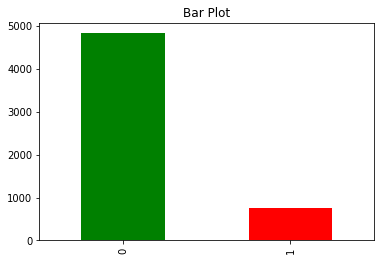

In [91]:
count_Class=pd.value_counts(dataset["label"], sort= True)
count_Class.plot(kind = 'bar',color = ["green","red"])
plt.title('Bar Plot')
plt.show();

In [53]:
f = feature_extraction.text.CountVectorizer(stop_words = 'english')
X = f.fit_transform(dataset["message"])
np.shape(X)

(5572, 8404)

**Implementing Naive Bayes**

In [32]:
# Classifying spam and not spam msgs as 1 and 0

dataset["label"]=dataset["label"].map({'spam':1,'ham':0})
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, dataset['label'], test_size=0.70, random_state=42)

In [33]:
list_alpha = np.arange(1/100000, 20, 0.11)
score_train = np.zeros(len(list_alpha))
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
count = 0
for alpha in list_alpha:
    bayes = naive_bayes.MultinomialNB(alpha=alpha)
    bayes.fit(X_train, y_train)
    score_train[count] = bayes.score(X_train, y_train)
    score_test[count]= bayes.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test))
    count = count + 1 

In [34]:
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)


,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,0.998803,0.961805,0.913793,0.820998
1,0.11001,0.998803,0.966163,0.946360,0.826087
2,0.22001,0.999402,0.967444,0.938697,0.837607
3,0.33001,0.999402,0.968726,0.938697,0.844828
4,0.44001,0.999402,0.971546,0.929119,0.867621
5,0.55001,0.998803,0.976160,0.925287,0.899441
6,0.66001,0.998803,0.976160,0.919540,0.903955
7,0.77001,0.997606,0.977698,0.917625,0.915870
8,0.88001,0.997606,0.977954,0.909962,0.924125
9,0.99001,0.997606,0.978980,0.902299,0.938247


In [35]:
best_index = models['Test Precision'].idxmax()
models.iloc[best_index, :]

alpha             10.670010
Train Accuracy     0.977259
Test Accuracy      0.962574
Test Recall        0.720307
Test Precision     1.000000
Name: 97, dtype: float64

**Random Forest Method**

In [57]:
rf = RandomForestClassifier(n_estimators=100,max_depth=None,n_jobs=-1)
rf_model = rf.fit(X_train,y_train)

In [58]:
y_pred=rf_model.predict(X_test)
precision,recall,fscore,support =score(y_test,y_pred,pos_label=1, average ='binary')
print('Precision : {} / Recall : {} / fscore : {} / Accuracy: {}'.format(round(precision,3),round(recall,3),round(fscore,3),round((y_pred==y_test).sum()/len(y_test),3)))

Precision : 0.995 / Recall : 0.726 / fscore : 0.839 / Accuracy: 0.963


**Using NLP techniques and using Tensorflow** 

In [74]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, LSTM, Dropout, Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf


In [75]:
vocab_size = 400
oov_tok = "<OOV>"
max_length = 250
embedding_dim = 16
encode = ({'ham': 0, 'spam': 1} )
#new dataset with replaced values
dataset = dataset.replace(encode)


In [76]:
X = dataset['message']
Y = dataset['label']
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)
# convert to sequence of integers
X = tokenizer.texts_to_sequences(X)

In [77]:
X = np.array(X)
y = np.array(Y)

In [78]:
X = pad_sequences(X, maxlen=max_length)

In [79]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 16)           6400      
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 6,833
Trainable params: 6,833
Non-trainable params: 0
_________________________________________________________________


In [82]:
num_epochs = 50
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.20, random_state=7)
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test,y_test), verbose=2)

Epoch 1/50
140/140 - 0s - loss: 0.0257 - accuracy: 0.9912 - val_loss: 0.0432 - val_accuracy: 0.9883
Epoch 2/50
140/140 - 0s - loss: 0.0251 - accuracy: 0.9915 - val_loss: 0.0439 - val_accuracy: 0.9883
Epoch 3/50
140/140 - 0s - loss: 0.0244 - accuracy: 0.9915 - val_loss: 0.0440 - val_accuracy: 0.9892
Epoch 4/50
140/140 - 0s - loss: 0.0251 - accuracy: 0.9917 - val_loss: 0.0445 - val_accuracy: 0.9883
Epoch 5/50
140/140 - 0s - loss: 0.0237 - accuracy: 0.9924 - val_loss: 0.0453 - val_accuracy: 0.9892
Epoch 6/50
140/140 - 0s - loss: 0.0237 - accuracy: 0.9921 - val_loss: 0.0444 - val_accuracy: 0.9883
Epoch 7/50
140/140 - 0s - loss: 0.0230 - accuracy: 0.9924 - val_loss: 0.0446 - val_accuracy: 0.9883
Epoch 8/50
140/140 - 0s - loss: 0.0234 - accuracy: 0.9926 - val_loss: 0.0471 - val_accuracy: 0.9901
Epoch 9/50
140/140 - 0s - loss: 0.0228 - accuracy: 0.9928 - val_loss: 0.0458 - val_accuracy: 0.9892
Epoch 10/50
140/140 - 0s - loss: 0.0264 - accuracy: 0.9912 - val_loss: 0.0507 - val_accuracy: 0.9901

In [84]:
results = model.evaluate(X_test, y_test)
loss = results[0]
accuracy = results[1]


print(f"[+] Accuracy: {accuracy*100:.2f}%")

35/35 [==============================] - 0s 1ms/step - loss: 0.0667 - accuracy: 0.9892
[+] Accuracy: 98.92%


**Doing the Predictions from the Model**

In [85]:
from keras.preprocessing import sequence

In [87]:
#Defining the function
def get_predictions(txts):
    txts = tokenizer.texts_to_sequences(txts)
    txts = sequence.pad_sequences(txts, maxlen=max_length)
    preds = model.predict(txts)
    if(preds[0] > 0.5):
        print("SPAM MESSAGE")
        
    else:
        print('NOT SPAM')

In [88]:
txts=["You have won a free ticket to las vegas. Contact now"]

get_predictions(txts)

SPAM MESSAGE


In [89]:
txts=["Hey there call me asap!!"]

get_predictions(txts)

NOT SPAM
